# Jupyter and multiple Languages

This notebook is [based on an oldnotebook of mine](https://matthiasbussonnier.com/posts/23-Cross-Language-Integration.html), and the supporting material behing a [Jupyter blog post](https://blog.jupyter.org/i-python-you-r-we-julia-baf064ca1fb6) talking about cross language integration.
This will quite short on narrative, and dive a bit more into technical details than the blog post does. 


An often requested feature for the [Jupyter Notebook](https://jupyter.org) is the ability to have multiple kernels, often in many languages, for a single notebook. 

While the request in spirit is a perfectly valid one, it is often a misunderstanding of what having a single kernel means. In particular having multiple language is often easier if you have a single process which handle the dispatching of various instructions to potentially multiple underlying languages. It is possible to do that in a _Single Kernel_ which does orchestrate dispatching instruction and moving data around.

Whether the multiple languages that get orchestrated together are remote processes, or simply library calls or more complex mechanisms becomes an implementation detail. 

[Python](https://python.org) is known to be a good "glue" language, and over the year the [IPython kernel](https://ipython.org) have seen a growing number of extensions showing that dynamic cross language integration can be seamless form the point of view of the user.

In the following we only scratch the surface of what is possible across a variety of languages. The approach shown here is one among many. The [Calysto](https://github.com/Calysto) organisation for example has several projects taking different approaches on the problem.

In the following I will show a quick overview on how you can in single notebook interact with many languages, via Common Foreign function interface (C, Rust, Fortran, ...), or even crazier approaches (Julia).


# IPython and cross language integration

The rest of this is mostly a demo on how cross-language integration works in a Jupyter notebook by using the features of the _Reference IPython Kernel implementation_. These features are completely handled in the kernel so need to be reimplemented on a per-kernel basis. Though they **also** work on pure terminal IPython, nbconvert or any other programmatic use of IPython.

Most of what you will see here are _just_ thin wrappers around already existing libraries. These libraries (and their respective authors) do all the heavy lifting. I just show how seamless a cross language environment can be from the user point of view. The installation of these library might not be easy either and getting all these language to play together can be complex task. It is though becoming easier and easier.

The term _just_ does not imply that the wrappers are simple, or easy to write. It indicate that the wrappers are far from being complete. What is shown here is completely doable using standard Python syntax and bit of manual work. SO what you'll see here is mostly _convenience_. 

### The good old example of Fibonacci

Understanding the multiple languages themselves is not necessary; most of the code here should self explanatory and straightforward. We'll define many function that compute the nth `Fibonacci` number more or less efficiently. We'll define them either using the classic recursive implementation, or sometime using an unrolled optimized version. As a reminder the Fibonacci sequence is defines a the following:

$$ F_n = \begin{cases} 1 &\mbox{if } n \leq 2 \\ 
F_{n-1}+F_{n-2} & \mbox{otherwise }\end{cases}$$

The fact that we calculate the Fibonacci sequence as little importance, except that the value of $F_n$ can grow _really_ fast in $O(e^n)$ if I remember correctly. And the recursive implementation will have a hard time getting beyond (n=100) as the number of call will be greater than $O(e^n)$ as well. Be careful especially if you calculate $F_{F_n}$ or more composition. Remembering that n=5 is stable via $F$ might be useful. 

Here are the first terms of the Fibonacci sequence:

 1. 1
 1. 1
 1. 1+1 = 2
 1. 2+1 = 3
 1. 3+2 = 5
 1. 5+3 = 8
 1. 8+5 = 13
 ...


# Basic Python cross-language integration

Let's define the `fibonacci` function in python:

In [1]:
def fib(n):
    """
    A simple definition of fibonacci manually unrolled
    """
    if n<2:
        return 1
    x,y = 1,1
    for i in range(n-2):
        x,y = y,x+y
    return y

In [2]:
[fib(i) for i in range(1,10)]

[1, 1, 2, 3, 5, 8, 13, 21, 34]

Store the value from 1 to 30 in `Y`, and graph it.

Text(0.5,1,'The Fibonacci sequence grows fast !')

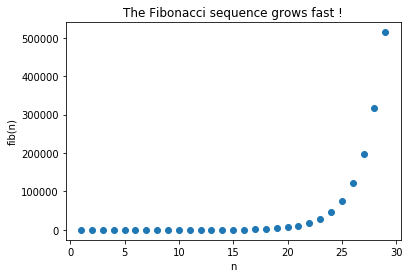

In [3]:
%matplotlib inline
import numpy as np
X = np.arange(1,30)
Y = np.array([fib(x) for x in X])
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(X, Y)
ax.set_xlabel('n')
ax.set_ylabel('fib(n)')
ax.set_title('The Fibonacci sequence grows fast !')

It may not surprise you, but this looks like an exponential, so if we were to look at $log(fib(n))$ × $n$ it would look approximately like a line. We can try to do a linear regression using this model. R is a language many people use to do statistics. So, let's use R. 

Let's enable integration between Python and R using the [__`RPy2`__](https://rpy2.readthedocs.io/en/version_2.8.x/) python package developed by Laurent Gautier and the rest of the rpy2 team.

In [4]:
import rpy2.rinterface

%load_ext rpy2.ipython

The Following will "Send" the X and Y array to R.

In [5]:
%Rpush Y X

And now let's try to fit a linear model ($ln(Y) = A.X + B$) using R. I'm not a R user myself, so don't take this as idiomatic R.

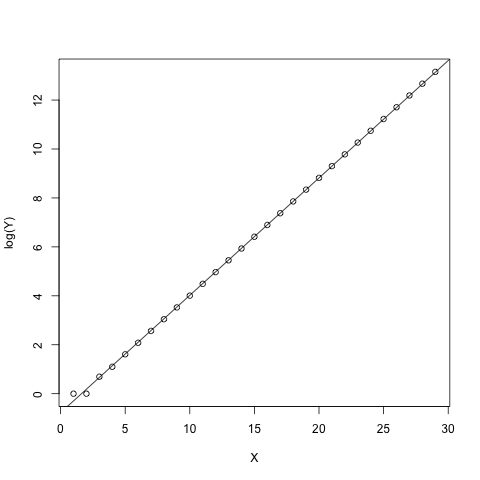

In [6]:
%%R
my_summary = summary(lm(log(Y)~X))
val <- my_summary$coefficients

plot(X, log(Y))
abline(my_summary)

In [7]:
%%R
my_summary


Call:
lm(formula = log(Y) ~ X)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.183663 -0.013497 -0.004137  0.006046  0.296094 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.775851   0.026173  -29.64   <2e-16 ***
X            0.479757   0.001524  314.84   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.06866 on 27 degrees of freedom
Multiple R-squared:  0.9997,	Adjusted R-squared:  0.9997 
F-statistic: 9.912e+04 on 1 and 27 DF,  p-value: < 2.2e-16



Good, we have now the some statistics on the fit, which also looks good. __And__ we were able to not only send variable to R, but to plot directly from R !

We are happy as $F_n = \left[\frac{\phi^n}{\sqrt 5}\right]$, where `[]` is closest integer and $\phi = \frac{1+\sqrt 5}{2}$

We can also look at the variables more carefully

In [8]:
%%R
val

              Estimate  Std. Error   t value     Pr(>|t|)
(Intercept) -0.7758510 0.026172673 -29.64355 3.910319e-22
X            0.4797571 0.001523832 314.83597 1.137181e-49


Or even the following that _looks_ more like python

In [9]:
%R val

array([[-7.75850975e-01,  2.61726725e-02, -2.96435519e+01,
         3.91031947e-22],
       [ 4.79757090e-01,  1.52383191e-03,  3.14835966e+02,
         1.13718145e-49]])

We can even get the variable back from R as Python objects:

In [10]:
coefs = %Rget val
y0,k = coefs[0:2]
y0,k

(array([-7.75850975e-01,  2.61726725e-02, -2.96435519e+01,  3.91031947e-22]),
 array([4.79757090e-01, 1.52383191e-03, 3.14835966e+02, 1.13718145e-49]))

That's all from the R part. I hope this shows you some of the power of IPython, both in notebook and command line. 

# CFFI

Great! We were able to send data back and forth! If does not works for all objects, but at least for the basic ones. It requires quite some work from the authors of the underlying library to allow you to do that. Though we are still limited to data. We can't (yet) send functions over which limits the utility.

## Mix and Match : C

One of the critical point of any code may at some point be performance. Python is known to not be the most performant language, though it is convenient and quick to write and has a large ecosystem. Most of the function you requires are probably available in a package, battle tested and optimized. 

You might still need here and there the raw power of an ubiquitous language which is known for its speed when you know how to wield it well: C. 

Though one of the disadvantage of C is the (relatively) slow  iteration process due to the necessity of compilation/run part of the cycle. Let see if we can improve that by leveraging the excellent [CFFI project](https://cffi.readthedocs.io/), using my own small [cffi_magic](https://pypi.python.org/pypi/cffi_magic) wrapper. 

In [11]:
import cffi_magic

In [12]:
rm -rf *.o *.c *.so Cargo.* src target

In [13]:
ls *.c *.h *.o

ls: *.c: No such file or directory
ls: *.h: No such file or directory
ls: *.o: No such file or directory


Using the `%%cffi` magic we can define in the middle of our python code some C function:

In [14]:
%%cffi int cfib(int);

int cfib(int n)
{
    int res=0;
    if (n <= 1){
        res = 1;
    } else {
        res = cfib(n-1)+cfib(n-2);
    }
    return res;
}

The first line take the "header"/"signature" of the function we declare, and the rest of the cell takes the body of this function. The `cfib` function will automatically be made available to you in the main python namespace.

In [15]:
cfib(5)

8

Oops there is a mistake as we should have `fib(5) == 5`. Luckily we can redefine the function on the fly. I could edit the above cell, but here as this will be rendered statically for the sake of demo purpose, I'm going to make a second cell:

In [17]:
%%cffi int cfib(int);

int cfib(int n)
{
    int res=0;
    if (n <= 2){  /*mistake was here*/
        res = 1;
    } else {
        res = cfib(n-1)+cfib(n-2);
    }
    return res;
}

(you may need to run above cell twice... I don't know why)

In [18]:
cfib(5)

5

Great ! Let's compare the timing.

In [19]:
%timeit cfib(10)

287 ns ± 10.8 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [20]:
%timeit fib(10)

902 ns ± 61 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Not so bad considering the C implementation is recursive, and the Python version is manually hand-rolled. 

### Implementation detail

So how do we do that magically under the hood? The knowledgeable reader is aware that CPython extensions cannot be reloaded. Though here we redefine the function... how come? 

Using the user provided code we compile a shared object with a random name, import this as a module and alias using a user friendly name in the `__main__` namespace. If the user re-execute we just get a new name, and change the alias mapping. 

If one wan to optimize you can use a hash of the codecell string to not recompile if the user hasn't changed the code. 

In [21]:
ls *.o *.c

_cffi_5c004d54c0a603cba22b0cb2067ddbe4.c
_cffi_5c004d54c0a603cba22b0cb2067ddbe4.o
_cffi_dcac8fc76ec118571b0ae4bda71fb975.c
_cffi_dcac8fc76ec118571b0ae4bda71fb975.o


With this in mind you can guess the same can be done for any language which can be compiled to a shared object, or a dynamically loadable library. 

## Mix and Match : rust

The `cffi` module also allows you to do the same with [Rust](https://www.rust-lang.org), a new language designed by Mozilla, which provide the same C-like level of control, while incorporating more recent understanding of programming and provide better memory safety. Let's see how we would do the same with Rust:

We need to put rustc on `$PATH`:

In [22]:
import cffi_magic
from os import environ as E
if 'cargo' not in E['PATH']:
    E['PATH'] = E['HOME']+'/.cargo/bin:'+E['PATH']

Fetching crates registry should take only 30sec or so... (if you know how to tell gargo not to hit the network). If it get stuck restart the notebook and "Run all above".

In [23]:
%%rust int rfib(int);

#[no_mangle]
pub extern fn rfib(n: i32) -> i32 {
    match n {
        0 => 1,
        1 => 1,
        2 => 1,
        _ => rfib(n-1)+rfib(n-2)
    }
}

injecting `rfib` in user ns


In [24]:
[rfib(x) for x in range(1,10)]

[1, 1, 2, 3, 5, 8, 13, 21, 34]

I'm not a Rustacean, but the above seem pretty straightforward to me. Again this might not be idiomatic Rust but you should be able to decipher what's above. The same than for C applies. 

### Still in development

Both the C and Rust example shown above use the `cffi_magic` on which I spent roughly 4 hours total, so the functionalities can be really crude and the documentation minimal at best. Feel free to send PRs if you are interested.  

## Fortran

The [fortran magic](https://pypi.python.org/pypi/fortran-magic) does the same as above, but has been developed by [mgaitan](https://github.com/mgaitan/fortran_magic) and is slightly older. Again no surprise except you are supposed to mark fortran variable that are used to return the values. 

In [25]:
%load_ext fortranmagic

/Users/bussonniermatthias/anaconda/lib/python3.6/site-packages/fortranmagic.py:147: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module since IPython 4.0.
  self._lib_dir = os.path.join(get_ipython_cache_dir(), 'fortran')


In [26]:
%%fortran
RECURSIVE SUBROUTINE ffib(n, fibo)  
    IMPLICIT NONE
    INTEGER, INTENT(IN) :: n
    INTEGER, INTENT(OUT) :: fibo
    INTEGER :: tmp
    IF (n <= 2) THEN 
        fibo = 1
    ELSE
        CALL ffib(n-1,fibo)
        CALL ffib(n-2,tmp)
        fibo = fibo + tmp
    END IF
END SUBROUTINE ffib

In [27]:
[ffib(x) for x in range(1,10)]

[1, 1, 2, 3, 5, 8, 13, 21, 34]

No surprise here, you are well aware of what we are doing.

## Cython

IPython used to ship with the Cython magic that is now part of [Cython](http://cython.org/) itself.
Cython is a superset of Python that compiles to C and importable from Python. You should be a ble to take your python code as is, type annotate it, and get c-like speed.
The same principle applies:

In [28]:
import cython

In [29]:
%load_ext cython

In [30]:
%%cython

def cyfib(int n): # note the `int` here
    """
    A simple definition of fibonacci manually unrolled
    """
    cdef int x,y # and the `cdef int x,y` here
    if n < 2:
        return 1
    x,y = 1,1
    for i in range(n-2):
        x,y = y,x+y
    return y

In [31]:
[cyfib(x) for x in range(1,10)]

[1, 1, 2, 3, 5, 8, 13, 21, 34]

###  benchmark

In [32]:
%timeit -n100 -r3 fib(5)

651 ns ± 25 ns per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [33]:
%timeit -n100 -r3 cfib(5)

The slowest run took 15.29 times longer than the fastest. This could mean that an intermediate result is being cached.
1.82 µs ± 2.07 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [34]:
%timeit -n100 -r3 ffib(5)

170 ns ± 8.86 ns per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [35]:
%timeit -n100 -r3 cyfib(5)

206 ns ± 204 ns per loop (mean ± std. dev. of 3 runs, 100 loops each)


The benchmark result can be astonishing, but keep in mind that the Python and Cython version use manually unrolled loop. Main point being that we reached our goal and used Fortran, Cython, C (and Rust) in the middle of our Python program.

 > let's skip the Rust fib version, it tends to segfault, and it would be sad to segfault now :-) If you konw why I would be happy to include a fix!

In [36]:
# %timeit rfib(10)

### The Cake is not a lie!

So can we do a layer cake? Can we call rust from Python from Fortran from Cython? Or Cython from C from Fortran? Or Fortron from Cytran from Rust?

In [37]:
import itertools
lookup = {'c':cfib,
       # 'rust': rfib, # as before Rust may segfault, but I dont' know why ...
       'python': fib,
       'fortran': ffib,
       'cython': cyfib
         }

print("Pray the demo-gods it wont segfault even without rust...")

Pray the demo-gods it wont segfault even without rust...


In [38]:
for function in lookup.values():
    assert function(5) == 5, "Make sure all is correct or will use 100% CPU for a looong time."

In [39]:
for order in itertools.permutations(lookup):
    t = 5
    for f in order:
        t = lookup[f](t)
    
    print(' -> '.join(order), ':', t)

c -> python -> fortran -> cython : 5
c -> python -> cython -> fortran : 5
c -> fortran -> python -> cython : 5
c -> fortran -> cython -> python : 5
c -> cython -> python -> fortran : 5
c -> cython -> fortran -> python : 5
python -> c -> fortran -> cython : 5
python -> c -> cython -> fortran : 5
python -> fortran -> c -> cython : 5
python -> fortran -> cython -> c : 5
python -> cython -> c -> fortran : 5
python -> cython -> fortran -> c : 5
fortran -> c -> python -> cython : 5
fortran -> c -> cython -> python : 5
fortran -> python -> c -> cython : 5
fortran -> python -> cython -> c : 5
fortran -> cython -> c -> python : 5
fortran -> cython -> python -> c : 5
cython -> c -> python -> fortran : 5
cython -> c -> fortran -> python : 5
cython -> python -> c -> fortran : 5
cython -> python -> fortran -> c : 5
cython -> fortran -> c -> python : 5
cython -> fortran -> python -> c : 5


In [40]:
print('It worked ! I can run all the permutations !')

It worked ! I can run all the permutations !


# The Cherry on the Layer Cake, with Julia

If you have a small idea about how the above layer-cake is working you'll understand that there is (still) a non-negligible overhead as between each language switch we need to go back to Python-land. And the scope in which we can access function is still quite limited. The following is some really _Dark Magic_ concocted by Fernando Perez and Steven Johnson using the [Julia](http://julialang.org/) programming language. I can't even pretend to understand how this possible, but it's really impressive to see. 

Let's try to handwave what's happening. I would be happy to get corrections.

The crux is that the Python and Julia interpreters can be started in a way where they each have access to the other process memory. Thus the Julia and Python interpreter can share live objects. You then "just" need to teach the Julia language about the structure of Python objects and it can manipulate these as desired, either directly (if the memory layout allow it) or using proxy objects that "delegate" the functionality to the python process.

The result being that Julia can import and use Python modules (using the Julia `PyCall` package), and Julia functions are available from within Python using the `pyjulia` module. 

Let's see how this look like.

In [41]:
%matplotlib inline

In [42]:
%load_ext julia.magic

Initializing Julia interpreter. This may take some time...


In [43]:
julia_version = %julia VERSION
julia_version # you can see this is a wrapper

<PyCall.jlwrap 0.6.1>

He we tell the _julia_ process to import the _python_ matplotlib module, as well as numpy.

In [44]:
%julia @pyimport matplotlib.pyplot as plt

In [45]:
%julia @pyimport numpy as np

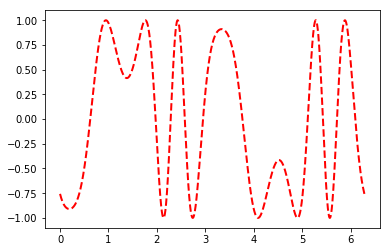

In [46]:
%%julia
                                        # Note how we mix numpy and julia:
t = linspace(0, 2*pi,1000);             # use the julia `linspace` and `pi`
s = sin(3*t + 4*np.cos(2*t));           # use the numpy cosine and julia sine
fig = plt.gcf()                         # **** WATCH THIS VARIABLE ****
plt.plot(t, s, color="red", linewidth=2.0, linestyle="--", label="sin(3t+4.cos(2t))")

All the above block of code is Julia, where, `linspace`,`pi`,`sin`  are builtins of Julia. `np.*` and `plt.*` are referencing Python function and methods.

We see that `t` is a Julia "Array" (technically a `1000-element LinSpace{Float64}`), which can get sent to `numpy.cos`, multiply by a Julia int, (..etc) and end up being plotted via matplotlib (Python), and displayed inline.

Let's finish our graph in Python

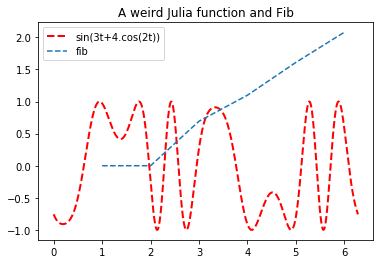

In [47]:
import numpy as np
fig = %julia fig
fig.axes[0].plot(X[:6], np.log(Y[:6]), '--', label='fib')
fig.axes[0].set_title('A weird Julia function and Fib')
fig.axes[0].legend()

fig

Above we get the reference to our previously defined figure (in Julia), plot the log of our `fib` function.
The key value here is that we get the _same_ object from within Python and Julia. But let's push even further.

Above we had _explicit_ transition between the Julia code and the Python code. Can we be more sneaky?

One toy example is to define the Fibonacci function using the recursive form and _explicitly_ pass the function with which we recurse.

We'll define such a function both on the Julia and Python side, ask the Julia function to recurse by calling the Python one, and the Python one to recurse using the Julia one.

Let's print `(P` when we enter Python Kingdom, `(J` when we enter Julia Realm, and close the parenthesis accordingly:

In [48]:
from __future__ import print_function


# julia fib function
jlfib = %julia _fib(n, pyfib) = n <= 2 ? 1 : pyfib(n-1, _fib) + pyfib(n-2, _fib)


def pyfib(n, _fib):
    """
    Python fib function
    """
    print('(P', end='')
    if n <= 2:
         r = 1
    else:
        print('(J', end='')
        # here we tell julia (_fib) to recurse using Python
        r =  _fib(n-1, pyfib) + _fib(n-2, pyfib)
        print(')',end='')
    print(')',end='')
    return r

In [49]:
fibonacci = lambda x: pyfib(x, jlfib)

fibonacci(10)

(P(J(P(J(P(J(P(J(P)(P)))(P(J))(P(J))(P)))(P(J(P(J))(P)(P)(P)))(P(J(P(J))(P)(P)(P)))(P(J(P)(P)))))(P(J(P(J(P(J))(P)(P)(P)))(P(J(P)(P)))(P(J(P)(P)))(P(J))))(P(J(P(J(P(J))(P)(P)(P)))(P(J(P)(P)))(P(J(P)(P)))(P(J))))(P(J(P(J(P)(P)))(P(J))(P(J))(P)))))

55

# Cross language is Easy

I hope you enjoyed that, I find it quite interesting and useful when you need to leverage the tools available across multiple domains. I'm sure there are plenty of other tools that allow this kind of things and a host of other languages that can interact with each other in this way.

From the top of my head I know of a few magics (SQL, Redis...) that provide such integration. Every language has its strong and weak points, and knowing what to use is often hard. I hope I convinced you that mixing languages is not such a daunting task.

The other case when this is useful is when you are learning a new language, you can leverage your current expertise temporarily and get something that work before learning the idiomatic way and available libraries.

You can head back to the [Jupyter blog post](https://blog.jupyter.org/i-python-you-r-we-julia-baf064ca1fb6) to read the end ! 

Happy codding.
